# House Price Predictive Modelling

The purpose of this notebook is to analyse the [Melbourne House Price dataset](https://www.kaggle.com/datasets/anthonypino/melbourne-housing-market?select=Melbourne_housing_FULL.csv) and create a linear regression model predicting the house price.

The structure is roughly as follows:
1. Data loading and cleaning
2. EDA
3. Modelling

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


## Data Loading and Cleaning

In [5]:
df = pd.read_csv("/content/Melbourne_housing_FULL.csv")
df.shape

(34857, 21)

In [6]:
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")

Going through column descriptions on Kaggle, I've decided which columns I will not use in this analysis. They can be removed.


In [ ]:
remove_columns = [
    "Suburb",
    "Address",
    "Postcode",
    "Method",
    "SellerG",
    "CouncilArea",
    "Lattitude",
    "Longtitude",
]

In [ ]:
df = df.drop(columns=remove_columns)

Let's look at a sample of data and see if I notice anything suspicious.

In [ ]:
df.sample(10)

,Rooms,Type,Price,Date,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Regionname,Propertycount
34690,3,t,1450000.0,2018-02-24,15.2,3.0,2.0,2.0,395.0,NaN,2000.0,Southern Metropolitan,4497.0
10738,1,u,285000.0,2016-09-10,8.9,1.0,1.0,1.0,0.0,NaN,NaN,Western Metropolitan,802.0
4176,3,h,NaN,2017-03-18,5.8,3.0,1.0,1.0,0.0,125.0,1925.0,Northern Metropolitan,2970.0
11382,4,h,2381000.0,2016-10-15,7.5,4.0,2.0,2.0,457.0,166.0,1900.0,Southern Metropolitan,6482.0
3708,3,h,1150000.0,2016-05-28,13.9,NaN,NaN,NaN,NaN,NaN,NaN,Eastern Metropolitan,9028.0
5301,3,h,NaN,2016-06-18,4.6,3.0,2.0,1.0,340.0,234.0,1890.0,Southern Metropolitan,11308.0
8746,2,u,635000.0,2017-03-04,2.6,2.0,2.0,1.0,2740.0,76.0,2003.0,Northern Metropolitan,14949.0
26555,3,u,NaN,2017-10-28,14.7,NaN,NaN,NaN,NaN,NaN,NaN,Eastern Metropolitan,7082.0
24803,4,h,2350000.0,2017-10-14,6.8,4.0,2.0,2.0,462.0,28.0,2000.0,Western Metropolitan,6380.0
3604,4,h,NaN,2016-06-04,13.9,5.0,3.0,2.0,652.0,481.0,1970.0,Eastern Metropolitan,9028.0


The first thing that pops out is the NaN values in the Price column. The ultimate goal of this analysis is to predict the house price. We have no use for rows with NaNs in our dependent variable.

In [ ]:
df = df.dropna(subset=["Price"])
df.shape

(27247, 13)

Another thing that"s apparent from the sample data is the significant number of NaNs in other columns. Let"s investgate that.

In [ ]:
df.isna().mean()

Rooms            0.000000
Type             0.000000
Price            0.000000
Date             0.000000
Distance         0.000037
Bedroom2         0.236393
Bathroom         0.236613
Car              0.250450
Landsize         0.340037
BuildingArea     0.608911
YearBuilt        0.556502
Regionname       0.000110
Propertycount    0.000110
dtype: float64

The share of NaN values in BuildingArea and YearBuilt columns is above 50%. This renders these columns pretty useless. Filtering out the rows where these columns are null would throw away half of the dataset, while imputing them later would create a significant bias.

Several other columns have issues with missing data as well, but that will be investigated further during EDA and modelling stage. What to do with missing data is ultimately a modelling decision.

In [ ]:
df = df.drop(columns=["BuildingArea", "YearBuilt"])

Lets inspect the dataset to see if there are any more issues.

In [ ]:
df.describe().round(2)


,Rooms,Price,Date,Distance,Bedroom2,Bathroom,Car,Landsize,Propertycount
count,27247.00,27247.00,27247,27246.00,20806.00,20800.00,20423.00,17982.00,27244.00
mean,2.99,1050173.34,2017-05-23 15:05:38.106947584,11.28,3.05,1.59,1.72,593.49,7566.78
min,1.00,85000.00,2016-01-28 00:00:00,0.00,0.00,0.00,0.00,0.00,83.00
25%,2.00,635000.00,2016-11-19 00:00:00,6.40,2.00,1.00,1.00,219.00,4294.00
50%,3.00,870000.00,2017-07-08 00:00:00,10.50,3.00,1.00,2.00,512.00,6567.00
75%,4.00,1295000.00,2017-10-28 00:00:00,14.00,4.00,2.00,2.00,664.00,10412.00
max,16.00,11200000.00,2018-03-17 00:00:00,48.10,20.00,9.00,18.00,433014.00,21650.00
std,0.95,641467.13,NaN,6.79,0.96,0.70,0.99,3757.27,4492.38


It seems Distance, Bedrooom2, Bathroom, Car and Landsize columns have two issues:
* The minimum value of these columns is 0. That needs to be investigated, because no home should have 0 bathrooms.
* These columns might have outliers. I will investigate this issue in the EDA step.

Lets look at those 0s.

In [ ]:
df.apply(lambda x: x == 0).mean()

Rooms            0.000000
Type             0.000000
Price            0.000000
Date             0.000000
Distance         0.002129
Bedroom2         0.000587
Bathroom         0.001248
Car              0.045913
Landsize         0.071274
Regionname       0.000000
Propertycount    0.000000
dtype: float64

Indeed these variables have a significant amount of 0s. It does not make any sense for Bedroom2 and Bathroom to have 0s, therefore those I will treat as anomalies/data entry mistakes and exclude.

For other variables, the documentation of the dataset did not provide any information for why they could be 0. I will keep those as is, but I will make the following assumptions. I do not know if these assumptions are true:
* Car - for this variable I'll assume that this means 0 car parking spots. That is a reasonable assumption.
* Landsize - this is a mysterious variable, but I'll assume that this means that the house is actually a flat that does not have a garden or other land.
* Distance - distance variable contains the distance of the house from the city centre. I do not know if the centre is defined as a single point in the city or a district. I'll assume that this means that the house is in the centre.

In [ ]:
df = df[(df["Bedroom2"] != 0) & (df["Bathroom"] != 0)]
df.shape

(27203, 11)

Now let's inspect the categorical variables.

In [ ]:
df["Type"].value_counts()

Type
h    18450
u     5891
t     2862
Name: count, dtype: int64

In [ ]:
df["Regionname"].value_counts()

Regionname
Southern Metropolitan         8499
Northern Metropolitan         7853
Western Metropolitan          5810
Eastern Metropolitan          3269
South-Eastern Metropolitan    1341
Eastern Victoria               166
Northern Victoria              166
Western Victoria                96
Name: count, dtype: int64

The categorial variables look quite healthy - no missing data or other issues. However, I don't like the cryptic "h", "u" and "t" coding in the Type variable. Let's transform it into something more readable.

In [ ]:
df["Type"] = df["Type"].map({"h": "house", "u": "unit", "t": "townhouse"})

That concludes the data loading and cleaning step. We have a dataframe with around 27 thousand rows.

## Exploratory Data Analysis

First lets look at the dependent variable in this analysis, Price.

<Axes: xlabel='Price', ylabel='Count'>

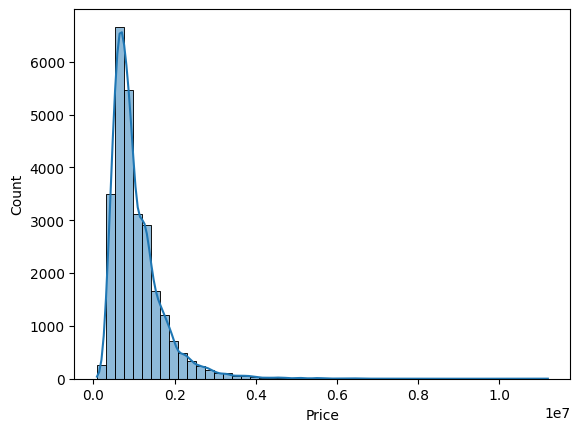

In [ ]:
sns.histplot(df.Price, bins=50, kde=True)

House price has a heavy right skew. It will be easier to interpret and work with if I take the logarithm of this variable.

In [ ]:
df["price_log"] = np.log(df["Price"])

Lets investigate which variables Price correlates the most with. For categorical/count variables I will use simple boxplots and for continuous variables I will use scatterplots.


<Axes: xlabel='Car', ylabel='price_log'>

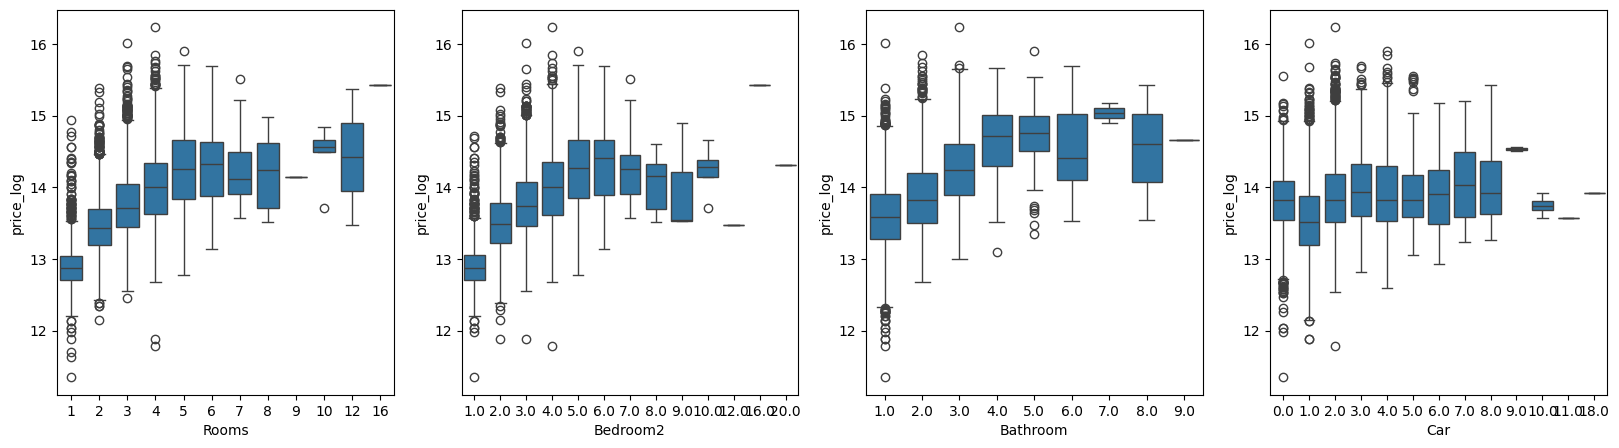

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
sns.boxplot(x="Rooms", y="price_log", data=df, ax=axs[0])
sns.boxplot(x="Bedroom2", y="price_log", data=df, ax=axs[1])
sns.boxplot(x="Bathroom", y="price_log", data=df, ax=axs[2])
sns.boxplot(x="Car", y="price_log", data=df, ax=axs[3])


This is quite interesting! The effect that the number of rooms, bedrooms and bathrooms has on the price seems to grow and then plateau at around 5. On average, a 5 room house costs as much as an 8 bedroom house. Meanwhile, the number of car parking spots does not seem to be correlated with price at all.

I also suspect that the Rooms variable might be heavily correlated with Bedroom2 + Bathroom. Let's inspect that.

In [ ]:
df["bathrooms_bedrooms"] = df["Bathroom"] + df["Bedroom2"]

In [ ]:
df[["Rooms", "bathrooms_bedrooms"]].corr()

,Rooms,bathrooms_bedrooms
Rooms,1.000000,0.904111
bathrooms_bedrooms,0.904111,1.000000


Indeed the correlation is very strong. This would mean that our suffer from multicollinearity if we included all of these variables. When making a predictive model, multicollinearity is not that big of an issue, but it will still complicate the interpretation of the model. Also, when looking for a home I personally don't care that much about the number of bathrooms, but rather the total number of rooms. Also, Bathroom and Bedroom2 had a significant proportion of missing rows and since Bathroom + Bedroom2 ~ Rooms, we can drop Bathroom and Bedroom2 variables without losing that much information. Hooray!

In [ ]:
df = df.drop(columns=["Bedroom2", "Bathroom"])

Let's inspect Type and Regionname variables.

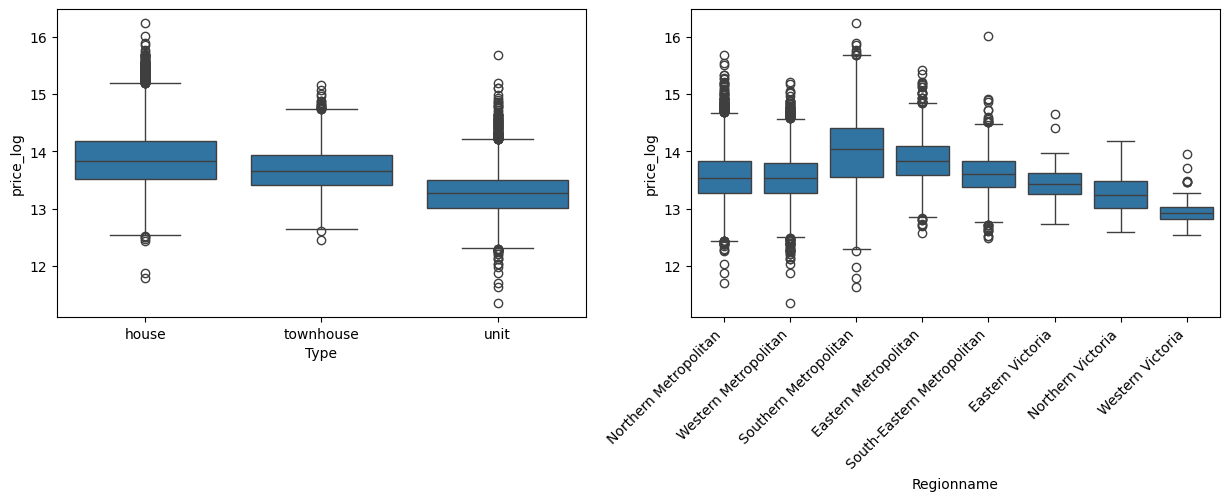

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.boxplot(x="Type", y="price_log", data=df, ax=axs[0])
sns.boxplot(x="Regionname", y="price_log", data=df, ax=axs[1])
plt.xticks(rotation=45, ha="right");


Both of these variables correlate with Price. House and townhouses are more expensive, while the Southern Metropolitan region seems to have pricier homes (although also more spread out).

Let's look at continuous variables now.

<Axes: xlabel='Propertycount', ylabel='price_log'>

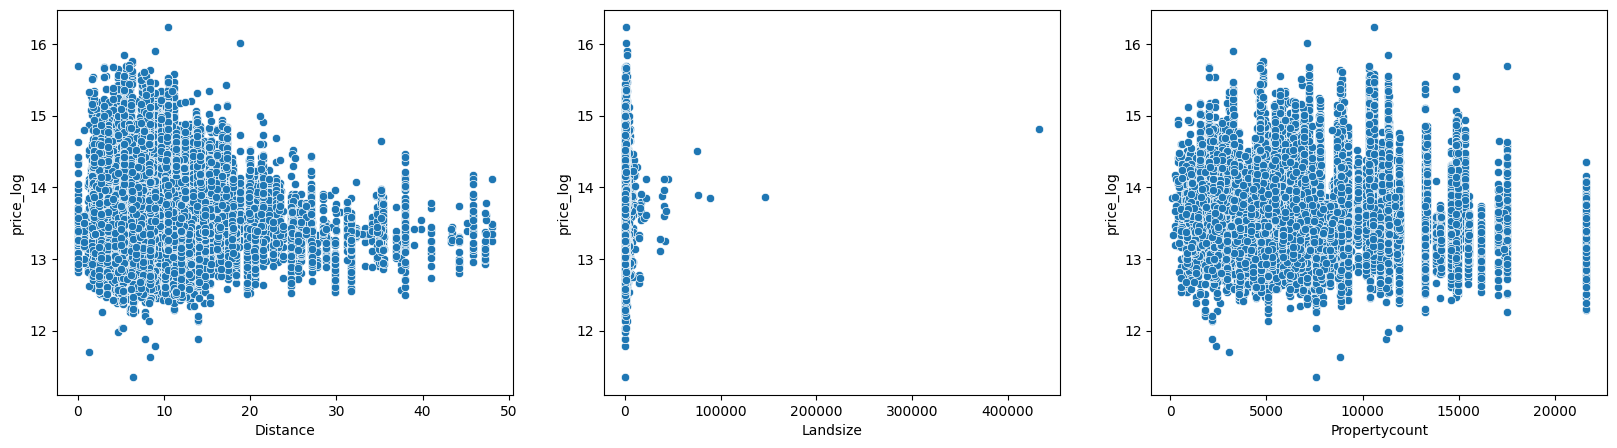

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
sns.scatterplot(x='Distance', y='price_log', data=df, ax=axs[0])
sns.scatterplot(x='Landsize', y='price_log', data=df, ax=axs[1])
sns.scatterplot(x='Propertycount', y='price_log', data=df, ax=axs[2])


It is immediately obvious that the Landsize variable has a significant outliers. They might complicate our modelling since the algorithm which I will use to fit my model, ordinary least squares, can be highly impacted by an outlier and that is not always desirable.

The good news is that I will never be interested in acquiring property with so much land. Everything that is above 10 thousand square meters does not interest me, because that is just too much land for me to bother taking care of. Therefore, I will exclude homes that have Landsize above 10000.

The effect this has on my analysis is that the population of houses to which my model will generalize is reduced. **That is OK** as long as I am making that decision consciously and keep it in mind when interpreting my model later in the analysis.

In [ ]:
df = df[df["Landsize"] < 10000]
df.shape

(17902, 11)

<Axes: xlabel='Landsize', ylabel='Count'>

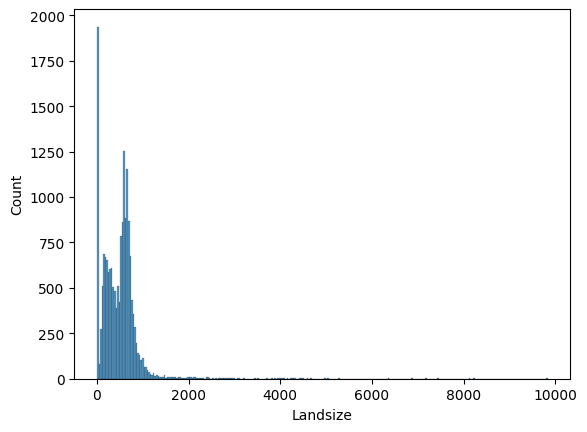

In [ ]:
sns.histplot(x='Landsize', data=df)


Still the Landsize variable is heavily skewed, lets log-transorm it. Taking the log of 0 is undefined, therefore we add 1. This is essentially assuming that even homes (flats) with no land have at least a square meter of land.

In [ ]:
df["log_landsize"] = np.log(df["Landsize"] + 1)

Lastly, let's inspect the Date variable. Maybe there is some seasonality going on?

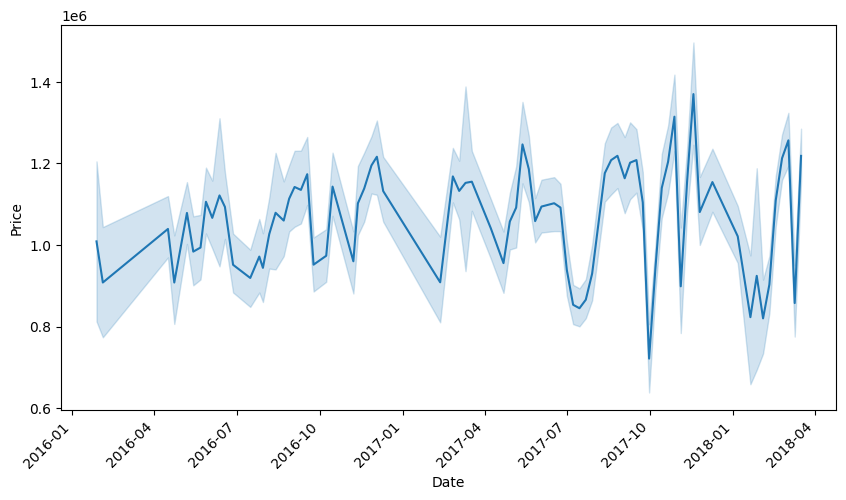

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(x='Date', y='Price', data=df)
plt.xticks(rotation=45, ha="right");


There seems to be a dip at around January, but the overall trend is volatile and hard to interpret. Let's investigate if there is a monthly pattern.

In [ ]:
df["month"] = df["Date"].dt.month

<Axes: xlabel='month', ylabel='price_log'>

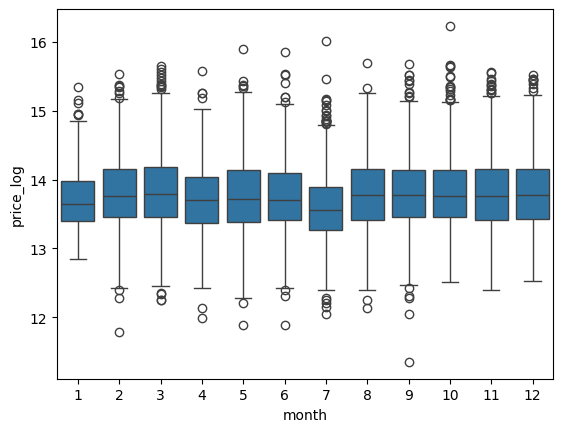

In [ ]:
sns.boxplot(x='month', y='price_log', data=df)

There is a visible dip in house prices at around January and July. However, this could just be a random dip.

This concludes the EDA! During the EDA above, I have made the following decisions before my modelling step:
* Log-transform the dependent variable, Price.
* Remove Bedroom2 and Bathroom variables.
* Remove rows where Landsize is above 10000 and log-transform the Landsize variable.

## Modelling


Time to fit that linear regression model! First I need to define the variables I will use in the model.

In [ ]:
categorical_feats = ["Type", "Regionname", "month"]
numerical_feats = ["Rooms", "Distance", "log_landsize", "Propertycount", "Car"]

y = df["price_log"]
X = df[categorical_feats + numerical_feats]

Then I need to split my data into a train set and a test set. I will use the test set at the very end of the notebook to report the accuracy of my model.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


Now lets encode the categorical variables so that we can feed them the model.

In [ ]:
encoder = OneHotEncoder(
    drop="first",
    # Hardcoded categories to avoid errors when the test set has missing categories
    categories=[
        ["house", "unit", "townhouse"],
        [
            "Northern Metropolitan",
            "Western Metropolitan",
            "Southern Metropolitan",
            "Eastern Metropolitan",
            "South-Eastern Metropolitan",
            "Eastern Victoria",
            "Northern Victoria",
            "Western Victoria",
        ],
        range(1, 13)
    ],
)


In [ ]:
X_train_categorical_encoded = pd.DataFrame(
    encoder.fit_transform(X_train[categorical_feats]).toarray(),
    columns=encoder.get_feature_names_out(categorical_feats),
    index=X_train.index,
)


In [ ]:
X_train_transformed = X_train.drop(columns=categorical_feats).join(X_train_categorical_encoded)


Lastly, we need to deal with missing values in the Car variable. I'll impute NaNs with the median.

In [ ]:
imputer = SimpleImputer(strategy="median")
X_train_transformed["Car"] = imputer.fit_transform(X_train_transformed[["Car"]])


Finally it is time to fit a model!


In [ ]:
model = LinearRegression(fit_intercept=True)
model.fit(X_train_transformed, y_train)


LinearRegression()

Let's look at the metrics on the training set.

In [ ]:
# R-squared
model.score(X_train_transformed, y_train)


0.6901904620040697

R-squared of 69% is not bad! This means that our model accounts for more than two thirds of the varianve in our dependent variable, log(price).

However, we should really inspect the performance on training data. For that we need to pass the X_test dataset through the encoder and the imputer. It's key to only transform the data. Refitting on the test set would amount to "leaking" information, which would overstate the true performance of our model.

In [ ]:
X_test_categorical_encoded = pd.DataFrame(
    # transform instead of fit_transform!
    encoder.transform(X_test[categorical_feats]).toarray(),
    columns=encoder.get_feature_names_out(categorical_feats),
    index=X_test.index,
)
X_test_transformed = X_test.drop(columns=categorical_feats).join(X_test_categorical_encoded)

# transform instead of fit_transform!
X_test_transformed["Car"] = imputer.transform(X_test_transformed[["Car"]])


In [ ]:
# R-squared
model.score(X_test_transformed, y_test)


0.6787637520717011

That is quite close to the training set performance, which is a good sign!

Now let's interpret the coefficients.

In [ ]:
# Coefficients
coefs = {feature: coef for feature, coef in zip(
    ["intercept"] + list(X_test_transformed.columns),
   [model.intercept_] + list(model.coef_),
)}
coefs

{'intercept': 13.342598913281448,
 'Rooms': 0.19234489503540533,
 'Distance': -0.0427841525851735,
 'log_landsize': 0.03640907961907816,
 'Propertycount': 1.19606878316279e-07,
 'Car': 0.030703363647100773,
 'Type_unit': -0.5053438833845166,
 'Type_townhouse': -0.17656016173110048,
 'Regionname_Western Metropolitan': -0.05628499883357625,
 'Regionname_Southern Metropolitan': 0.4545883762667823,
 'Regionname_Eastern Metropolitan': 0.28997678154799095,
 'Regionname_South-Eastern Metropolitan': 0.4928493661128958,
 'Regionname_Eastern Victoria': 0.6275625537857416,
 'Regionname_Northern Victoria': 0.3449822111538922,
 'Regionname_Western Victoria': 0.013734148209230157,
 'month_2': -0.021889307553317083,
 'month_3': -0.0041680174640067475,
 'month_4': -0.034714153991805684,
 'month_5': -0.03876847129060483,
 'month_6': -0.0392570921684143,
 'month_7': -0.0713401570455937,
 'month_8': -0.030015578714801643,
 'month_9': -0.024776960286706146,
 'month_10': -0.029743284569307187,
 'month_11':

How do we interpret this? These coefficients essentially show how much we can expect the average value of log(price) to change with one-unit change in the dependent variable. For example, the coefficient near Distance variable says that, all else equal, being one kilometer further away from the centre equates to 0.043 lower log of house price. We can make this easier to interpret by transforming the coefficient.


In [ ]:
np.exp(coefs["Distance"]) - 1

-0.04188182491958803

On average, being one kilometer further from the centre results in 4.2% lower house price. Lets try another variable.

In [ ]:
np.exp(coefs["Regionname_Southern Metropolitan"]) - 1

0.5755247261723064

Southern Metropolitan must be a rather fancy neighbourhood - all else equal, houses there are 57% more expensive than elsewhere!

Let's inspect several predictions.

In [ ]:
y_pred = model.predict(X_test_transformed)
df_test = X_test.copy()
df_test["price_log_pred"] = y_test
df_test["price_pred"] = np.exp(y_pred)
df_test["price"] = np.exp(y_test)


In [ ]:
df_test.sample(5)

,Type,Regionname,month,Rooms,Distance,log_landsize,Propertycount,Car,price_log_pred,price_pred,price
17141,unit,Eastern Metropolitan,5,3,17.2,5.342334,6871.0,2.0,13.560618,5.330383e+05,775000.0
33542,house,Eastern Metropolitan,3,4,17.2,6.230481,6871.0,2.0,14.007782,1.145068e+06,1212000.0
12606,house,Northern Metropolitan,5,4,3.4,5.726848,2954.0,2.0,14.417091,1.465949e+06,1825000.0
16246,house,Northern Metropolitan,6,3,13.1,6.424869,5070.0,4.0,13.384728,8.708696e+05,650000.0
34152,house,Northern Metropolitan,2,4,20.6,6.107023,15510.0,2.0,13.161584,7.253057e+05,520000.0


Even though on the log scale the performance of the model seems good, comparing predicted and actual prices we see that the performance could be improved. Also, predicting house prices is hard!



## Improvements

This is a quick analysis and a lot of improvements could be made to it.
* **Make train test split more realistic**. By default, `train_test_split` splits the dataset randomly. However, our model is meant to forecast house prices in the real world, so a more realistic split would use the last half year of sales as in the test set.
* Using cross-validation experiment with more advanced modelling techniques:
  * **More variable transformations**, e.g. [Standard Scaling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) or adding polynomials.
  * **Regularization and feature selection**. Ridge regression and Lasso regression are simple extensions of the linear model that would allow us to control the complexity of the model.
* **Use Pipelines**. Feeding data into the model to get a prediction is kind of messy and requires multiple steps. For both training and testing data we had to repeat essentially the same steps, which resulted in a lot of repetitive code. scikit-learn [Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) should be used here.
* **Missing data imputation needs to be performed more carefully**. Missing data in the Car column could itself be a predictor of price, in which case we should have added a binary variable indicating which rows were missing. This could be done using the `add_indicator` in SimpleImputer.
* **Use confidence intervals**. A more actionable prediction would be not a point estimate, but instead an interval of reasonable house prices given input the input variables. Scikit-learn does not provide methods for computing confidence intervals, but statsmodels does.
